In [149]:
%reload_ext autoreload
%autoreload 2
# general libraries
import random
from datetime import timedelta
# local libraries
from tsmissing import TsMissing
# data manipulation libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
# data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from dash import Dash, dcc, html, Input, Output
# machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.impute import KNNImputer, SimpleImputer, MissingIndicator

# silence warnings
import warnings
warnings.filterwarnings("ignore")

# Just to iterate faster 

df = pd.read_csv('exchange_rate_with_missing.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
# change frequency to daily
df.asfreq('D')


normalized_df = df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# costume class to handle TimeSeries missing values
tsm = TsMissing(data=normalized_df)

### Load data

In [150]:
df = pd.read_csv('exchange_rate_with_missing.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
# change frequency to daily
df.asfreq('D')

,0,1,2,3,4,5,6,OT
date,,,,,,,,
1990-01-01,0.785500,1.611000,0.861698,0.634196,0.211242,0.006838,0.525486,NaN
1990-01-02,0.781800,1.610000,0.861104,0.633513,0.211242,0.006863,0.523972,NaN
1990-01-03,0.786700,1.629300,0.861030,0.648508,0.211242,0.006975,0.526316,NaN
1990-01-04,0.786000,1.637000,0.862069,0.650618,0.211242,0.006953,0.523834,NaN
1990-01-05,0.784900,1.653000,0.861995,0.656254,NaN,0.006940,0.527426,NaN
...,...,...,...,...,...,...,...,...
2010-06-28,0.749176,1.300500,0.756802,NaN,0.149851,0.009778,0.730941,0.726401
2010-06-29,0.754290,1.302932,0.757579,NaN,0.150004,0.009830,0.734498,0.730007
2010-06-30,0.754205,1.297353,0.756024,NaN,0.149813,0.009823,0.733708,0.730727


### Normalize data

In [151]:
normalized_df = df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# Advanced Exploration Of Missing Values 

We will see how the type of missing values we have .. in terms of frequency .. length of gaps (missing data) and how they are distributed 


In [152]:
# costume class to handle TimeSeries missing values
tsm = TsMissing(data=normalized_df)

In [153]:
print("How many data pieces (continuous) are there in the data?")
for key,intervals in tsm.intervals_not_missing.items():
    print(key,len(intervals))
print("Average:",np.mean([len(x) for x in tsm.intervals_not_missing.values()]))

print("How many missing gaps/holes are there in the data?")
for key,intervals in tsm.intervals_missing.items():
    print(key,len(intervals))
print("Average:",np.mean([len(x) for x in tsm.intervals_missing.values()]))


How many data pieces (continuous) are there in the data?
0 169
1 156
2 159
3 155
4 168
5 163
6 168
OT 165
Average: 162.875
How many missing gaps/holes are there in the data?
0 168
1 155
2 158
3 155
4 167
5 162
6 167
OT 165
Average: 162.125


### Missing values intervals lengths distribution

We can see that most gaps (missing values intervals) are less or equal to 50daysm

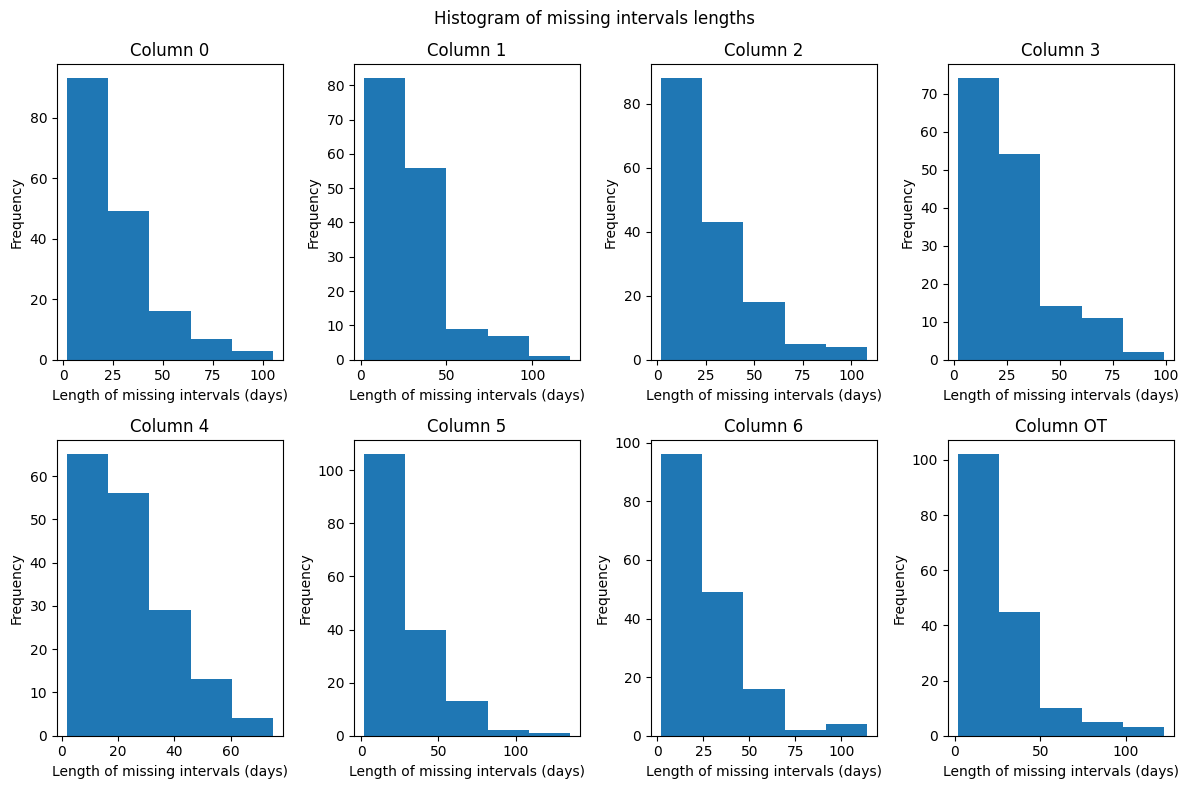

In [154]:
fig, axes = plt.subplots(nrows=len(tsm.df.columns)//4, ncols=4, figsize=(12, 8))
for i, column in enumerate(tsm.df.columns):
    axes[i//4, i%4].hist(tsm.intervals_lengths_missing[column], bins=5)
    axes[i//4, i%4].set_ylabel('Frequency') 
    axes[i//4, i%4].set_xlabel('Length of missing intervals (days)')
    axes[i//4, i%4].set_title(f'Column {column}')

plt.suptitle('Histogram of missing intervals lengths')
plt.tight_layout()
plt.show()

### probabilities of each interval length


In [155]:
column = '6'
print(f"Column {column} bins: {tsm.bins[column]}")
print(f"Column {column} probabilities: {tsm.bins_probabilities[column]}")
print(f"probabilty of length being less or equal to {tsm.bins[column][4]} is == {round(tsm.bins_probabilities[column][:5].sum()*100)}%")

Column 6 bins: [2, 13, 24, 35, 46, 58, 69, 80, 91, 102, 114]
Column 6 probabilities: [0.32934132 0.24550898 0.19161677 0.10179641 0.05389222 0.04191617
 0.00598802 0.00598802 0.01197605 0.01197605]
probabilty of length being less or equal to 46 is == 92%


In [156]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.graph_objects as go

# Create a Dash app
app = dash.Dash(__name__)

# Define the layout of the app
app.layout = html.Div([
    dcc.Dropdown(
        id='column-dropdown',
        options=[{'label': col, 'value': col} for col in df.columns],
        value='6',
        multi=False,       
    ),
    
    dcc.Graph(id='graph')
])

# Define the callback function to update the graph based on the selected column
@app.callback(
    Output('graph', 'figure'),
    Input('column-dropdown', 'value'),
)

def update_graph(column,):
    fig = go.Figure(data=go.Scatter(x=df.index, y=df[column]))
    for i,interval in enumerate(tsm.intervals_missing[column]):
        # Add a rectangle for each interval of missing values
        fig.add_shape(
            type="rect",
            x0=interval[0],
            y0=df[column].min(),
            x1=interval[1],
            y1=df[column].max(),
            line=dict(
                color="Red",
                width=2,
            ),
            fillcolor="Red",
            opacity=0.5,
        )
    
    # indicate the meaning of the red rectangles
    fig.add_annotation(
        xref="paper", yref="paper",
        x=0.5, y=1.1,
        text="Red rectangles indicate missing gaps in the data.",
        showarrow=False,
        font=dict(size=14), 
    )
    # remove gaps between 
    fig.update_layout(title=f'Exchange rate for column {column}')
    # change axis x type to numeric
    fig.update_xaxes(title_text='Date')
    fig.update_yaxes(title_text='Exchange rate')
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, port=8060)


## Imputing the data 

there are multiple ways to impute the data .. we will explore multiple them and compare them visually and using a metric by creating on purpose missing values to test
the imputation techniques

In [187]:
# generate test missing intervals (1/3 of clean data) while keeping the original distribution of missing intervals lengths
test_index = {}
original_minus_null_index = {}
for column in tsm.df.columns:
    test_index[column] = tsm.generate_test_intervals(column=column, test_size=50, random_state=42, strategy='real')
    original_minus_null_index[column] = list(set(tsm.df[column].loc[tsm.index_not_missing[column]].index).difference(set(test_index[column])))

In [189]:
df_missing = normalized_df.copy()
# Store the true values of the missing values
y_true = normalized_df[column].loc[test_index[column]]
# Set the values of the missing test values to NaN
df_missing[column].loc[test_index[column]] = np.nan
# Impute the missing values using forward fill
df_missing[column] = df_missing[column].ffill()
# Store the predicted values of the missing values
y_pred_ffill = df_missing[column].loc[test_index[column]]
# Calculate the mean squared error
mse_ffill = mean_squared_error(y_true, y_pred_ffill)
print(f'The mean squared error of the forward fill method is {mse_ffill}')


The mean squared error of the forward fill method is 0.000737451143935637


In [190]:
#y_true,y_pred_ffill,index_missing_index[column],not_missing_intervals[column]

df_plot = pd.DataFrame(index=normalized_df.index)
df_plot['True test values'] = pd.NA
df_plot['True test values'].loc[y_true.index] = y_true
df_plot['Predicted test values'] = pd.NA
df_plot['Predicted test values'].loc[test_index[column]] = y_pred_ffill
df_plot['Not missing values'] = pd.NA
df_plot['Not missing values'].loc[original_minus_null_index[column]] = normalized_df[column].loc[original_minus_null_index[column]]
df_plot['Predicted values'] = pd.NA
df_plot['Predicted values'].loc[tsm.index_missing_values[column]] = df_missing[column].loc[tsm.index_missing_values[column]]

figure = go.Figure()
figure.add_trace(go.Scatter(x=df_plot.index, y=df_plot['True test values'], mode='lines+markers', name='True test values'))
figure.add_trace(go.Scatter(x=df_plot.index, y=df_plot['Predicted test values'], mode='lines+markers', name='Imputed test values'))
figure.add_trace(go.Scatter(x=df_plot.index, y=df_plot['Not missing values'], mode='lines', name='Not missing values'))
figure.add_trace(go.Scatter(x=df_plot.index, y=df_plot['Predicted values'], mode='lines', name='Imputed values'))
figure.update_xaxes(rangeslider_visible=True)
figure.show()

In [188]:
df_missing = normalized_df.copy()
df_missing[column].loc[test_index] = np.nan
# Store the true values of the missing values
y_true = normalized_df[column].loc[test_index]
# Impute the missing values using backward fill
df_missing[column] = df_missing[column].bfill()
# Store the predicted values of the missing values
y_pred_bfill = df_missing[column].loc[test_index]
# Calculate the mean squared error
mse_bfill = mean_squared_error(y_true, y_pred_bfill)
print(f'The mean squared error of the backward fill method is {mse_bfill}')

TypeError: Passing a dict as an indexer is not supported. Use a list instead.

In [15]:
df_missing = normalized_df.copy()
df_missing[column].loc[test_index] = np.nan
# Store the true values of the missing values
y_true = normalized_df[column].loc[test_index]
# Impute the missing values using the mean of the column
df_missing[column] = df_missing[column].fillna(df_missing[column].mean())
# Store the predicted values of the missing values
y_pred_mean = df_missing[column].loc[test_index]
# Calculate the mean squared error
mse_mean = mean_squared_error(y_true, y_pred_mean)
print(f'The mean squared error of the mean method is {mse_mean}')


The mean squared error of the mean method is 0.07171882300828182


In [16]:
df_missing = normalized_df.copy()
df_missing[column].loc[test_index] = np.nan
# Store the true values of the missing values
y_true = normalized_df[column].loc[test_index]
# Impute the missing values using linear interpolation
df_missing[column] = df_missing[column].interpolate(method='linear')
# Store the predicted values of the missing values
y_pred_mean = df_missing[column].loc[test_index]
# Calculate the mean squared error
mse_mean = mean_squared_error(y_true, y_pred_mean)
print(f'The mean squared error of the mean method is {mse_mean}')

The mean squared error of the mean method is 0.00017067331136884605


In [17]:
df_missing = normalized_df.copy()
df_missing[column].loc[test_index] = np.nan
# Store the true values of the missing values
y_true = normalized_df[column].loc[test_index]
# Impute the missing values using linear interpolation
df_missing[column] = df_missing[column].interpolate(method='nearest')
# Store the predicted values of the missing values
y_pred_mean = df_missing[column].loc[test_index]
# Calculate the mean squared error
mse_mean = mean_squared_error(y_true, y_pred_mean)
print(f'The mean squared error of the mean method is {mse_mean}')

The mean squared error of the mean method is 0.00033740527638503095
